In [6]:
from typing import Union, Sequence, List
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from src.helper_methods import feature_scaler, plot_kaplan_meier_curve
from src.pipe_store import *
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import statsmodels.api as sm
import statsmodels.formula.api as smf 

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# notebook works with jupyter notebook and widget works better with jupyter lab. In case of
# problem with implementation look at the link https://github.com/matplotlib/ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
print(plt.style.available)
plt.style.use('fivethirtyeight') 

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Helper Methods

In [8]:
def create_treatment_grups(df, quant_groups:int):
    if quant_groups == 3:
        df = df.assign(
                    No_DESA = df['DESA'].apply(lambda x: 0 if x else 1),
                    DESA_12 = df['#DESA'].apply(lambda x: 1 if (x >= 1) & (x <= 2) else 0),
                    DESA_3ormore = df['#DESA'].apply(lambda x: 1 if x >= 3 else 0),
                )
        return df.assign(
            Groups = df[['No_DESA', 'DESA_12', 'DESA_3ormore']].values.argmax(1) + 1
        )

    elif quant_groups == 4:
        df = df.assign(
                    No_DESA = df['DESA'].apply(lambda x: 0 if x else 1),
                    DESA_12 = df['#DESA'].apply(lambda x: 1 if (x >= 1) & (x <= 2) else 0),
                    DESA_34 = df['#DESA'].apply(lambda x: 1 if (x >= 3) & (x <= 4) else 0),
                    DESA_5ormore = df['#DESA'].apply(lambda x: 1 if x >= 5 else 0),
                )
        return df.assign(
                    Groups = df[['No_DESA', 'DESA_12', 'DESA_34', 'DESA_5ormore']].values.argmax(1) + 1
                )
    else:
        raise ValueError('DESA Quantity Group is not recognised. Valid values are 3 or 4')

def _get_indexes(df, donor_type, quant_groups:Union[str, Sequence]=None):
    if 'TypeOfDonor_NOTR' in df.columns:
        ind_donor = df.TypeOfDonor_NOTR == donor_type 
    else:
        ind_donor = df.Donor_Type == donor_type
    ind_desa = df['#DESA'] != 0
    ind_T1 = ~ind_desa & ind_donor
    if quant_groups == 3:
        ind_12 = df['#DESA'].apply(lambda x: (x >= 1) & (x <= 2)) 
        ind_T2 = ind_desa & ind_donor & ind_12
        ind_T3 = ind_desa & ind_donor & ~ind_12

        assert len(df[ind_donor]) == sum(ind_T1) + sum(ind_T2) + sum(ind_T3), 'indexes do not add up'
        return ind_T1, ind_T2, ind_T3

    elif quant_groups == 4: 
        ind_12 = df['#DESA'].apply(lambda x: (x >= 1) & (x <= 2)) 
        ind_34 = df['#DESA'].apply(lambda x: (x >= 3) & (x <= 4)) 
        ind_T2 = ind_desa & ind_donor & ind_12
        ind_T3 = ind_desa & ind_donor & ind_34
        ind_T4 = ind_desa & ind_donor & ~(ind_34 | ind_12)

        assert len(df[ind_donor]) == sum(ind_T1) + sum(ind_T2) + sum(ind_T3) + sum(ind_T4), 'indexes do not add up'
        return ind_T1, ind_T2, ind_T3, ind_T4
    else:
        raise ValueError('DESA Quantity Group is not recognised. Valid values are 3 or 4')

def kaplan_meier_curves(df:pd.DataFrame, 
                        quant_groups:int,
                        donor_type:str='Deceased',
                        labels:list=None,
                        adjust=False):


    assert 'Groups' in df.columns, 'Groups column is missing'
    if 'GraftSurvival10Y_R' in df.columns:
        failure, time = 'FailureCode10Y_R', 'GraftSurvival10Y_R'
    else:
        failure, time = 'Failure', 'Survival[Y]'

    inds = _get_indexes(df, donor_type=donor_type, quant_groups=quant_groups)

    T = [df.loc[ind, time] for ind in inds]
    E = [df.loc[ind, failure] for ind in inds]
    if adjust:
        assert 'w' in df.columns, 'Weight column is missing'
        W = [df.loc[ind, 'w'] for ind in inds]
    else:
        W = [None] * quant_groups
    t = np.linspace(0, 10, 1000)
    kmfs = [
        KaplanMeierFitter(label=labels[i])
        .fit(T[i], event_observed=E[i], timeline=t, weights=W[i]) for i in range(len(inds)) 
    ]
    # Calculate the p-value 
    df_p = df[df.TypeOfDonor_NOTR == donor_type]
    p_value = multivariate_logrank_test(
        df_p['GraftSurvival10Y_R'], df_p['Groups'], df_p['FailureCode10Y_R']
        ).p_value
    return kmfs, p_value, df_p

def find_ipw(df, confounders, treatments, scaler='standard', num_col:list=None, verbose=False,) -> pd.Series:
    """ 
    This method finds the inverse probability weights use in causal inference per treatment group 
    This method already carries out the scaling by default. Thus, be advised not to do feeature scaling before.

    Parameters:
    num_col: List[str], None
        Numerical columns to be scaled. If nothing is passed in, feature scaler uses its default
        columns for scaling. 
    """

    df_ipw = df.copy(deep=True)
    
    # scale the features
    if scaler:
        df_ipw = feature_scaler(df_ipw, num_col, scaler=scaler)
    
    # Propensity model
    formulas = [treatment + ' ~ ' + ' + '.join(confounders) for treatment in treatments]
    models = [
        smf.glm(formula=formulas[i], data=df_ipw, family=sm.families.Binomial())
        .fit() for i in range(len(treatments))
    ]

    # Propensity scores 
    propensity_scores = np.array([model.fittedvalues for model in models])
    p = propensity_scores/sum(propensity_scores)

    if verbose:
        print(summary_col(models))
        # print('sum propensity score', sum(propensity_scores))

    # Calculate the weights
    df_ipw['w'] = sum([(df_ipw[treatment]==1) / p[i] for i, treatment in enumerate(treatments)])
    return df_ipw

# Load Dataset

In [10]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', 
]
num_col = ['CIPHour_DBD', 'CIPHour_DCD']
df = (
    df[cols]
    .pipe(polynomial_power2, 'DonorAge_NOTR', 'RecipientAge_NOTR')
    .pipe(feature_scaler, num_col + ['DonorAge_NOTR_power2', 'RecipientAge_NOTR_power2'], scaler='standard')
)

# Quantity of DESA 

In [11]:
confounders = [
    'RecipientAge_NOTR',
    'RecipientAge_NOTR_power2',
    'DonorAge_NOTR', 
    'DonorAge_NOTR_power2',
    'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

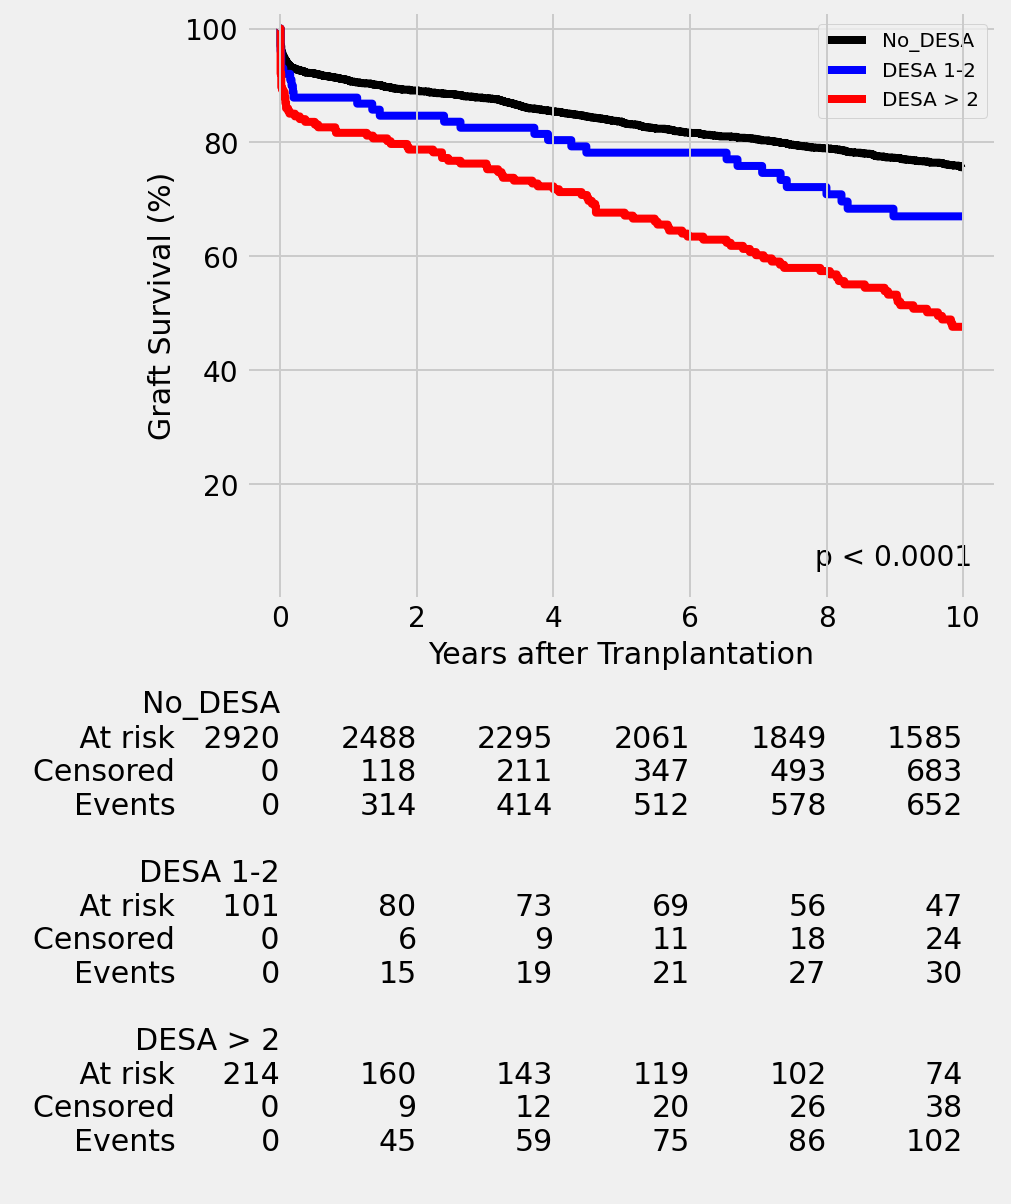

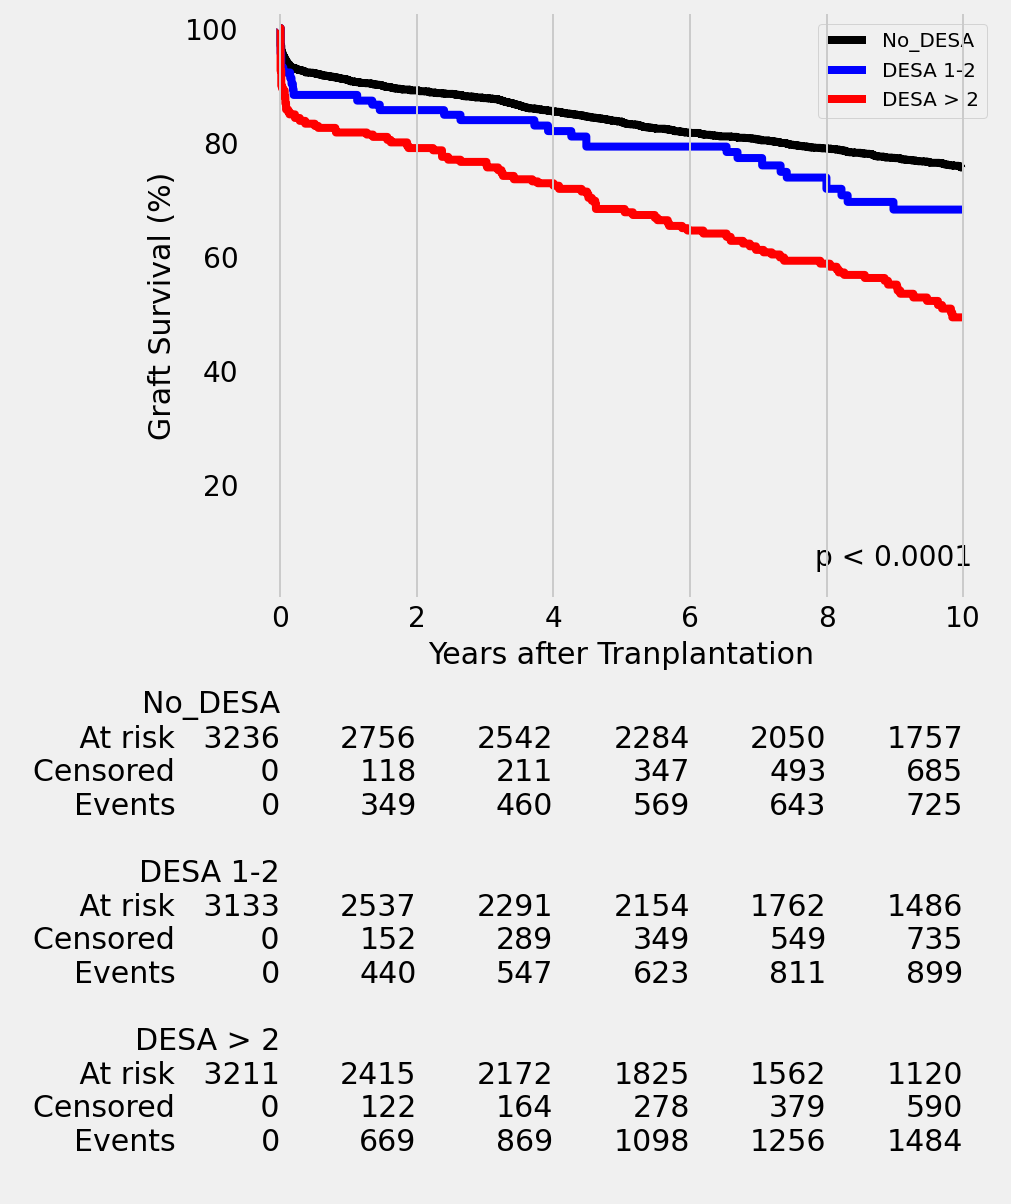

In [12]:
quant_groups = 3
df_treat_group = create_treatment_grups(df, quant_groups=quant_groups)

treatments = ['No_DESA', 'DESA_12', 'DESA_3ormore']
labels = ['No_DESA', 'DESA 1-2', 'DESA > 2']
colors = ['black', 'blue', 'red']
df_weight = find_ipw(df_treat_group, confounders, treatments, scaler=None, verbose=False)
kmfs, p_value,_ = kaplan_meier_curves(df_weight, quant_groups=quant_groups, labels=labels, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, grid=True, colors=colors)

kmfs, p_value,_ = kaplan_meier_curves(df_weight, quant_groups=quant_groups, labels=labels, adjust=True)
plot_kaplan_meier_curve(kmfs, p_value, grid=False, colors=colors)

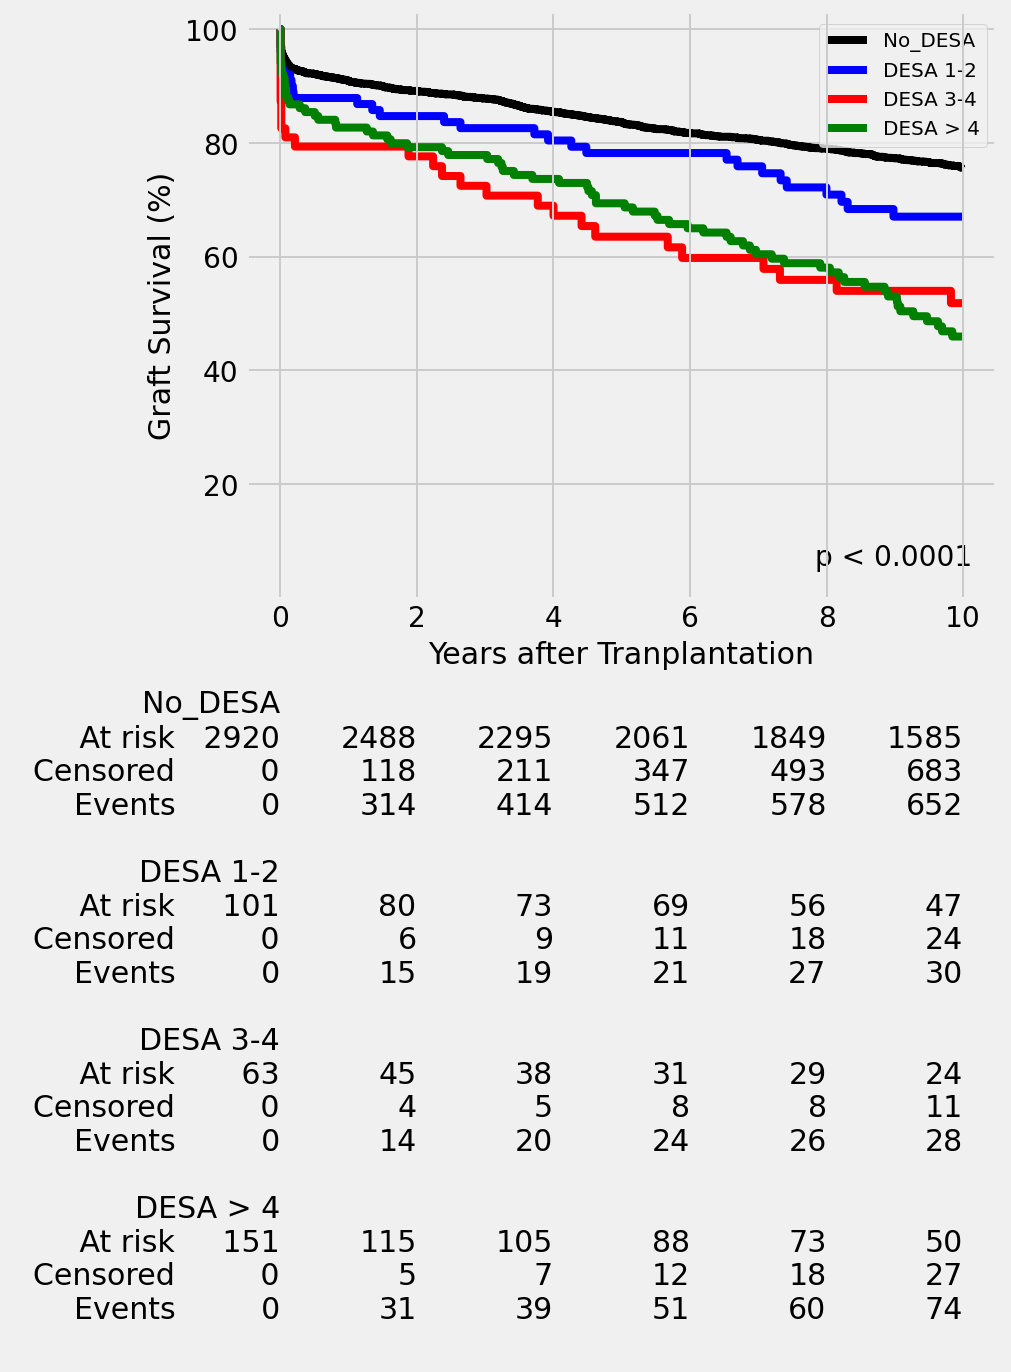

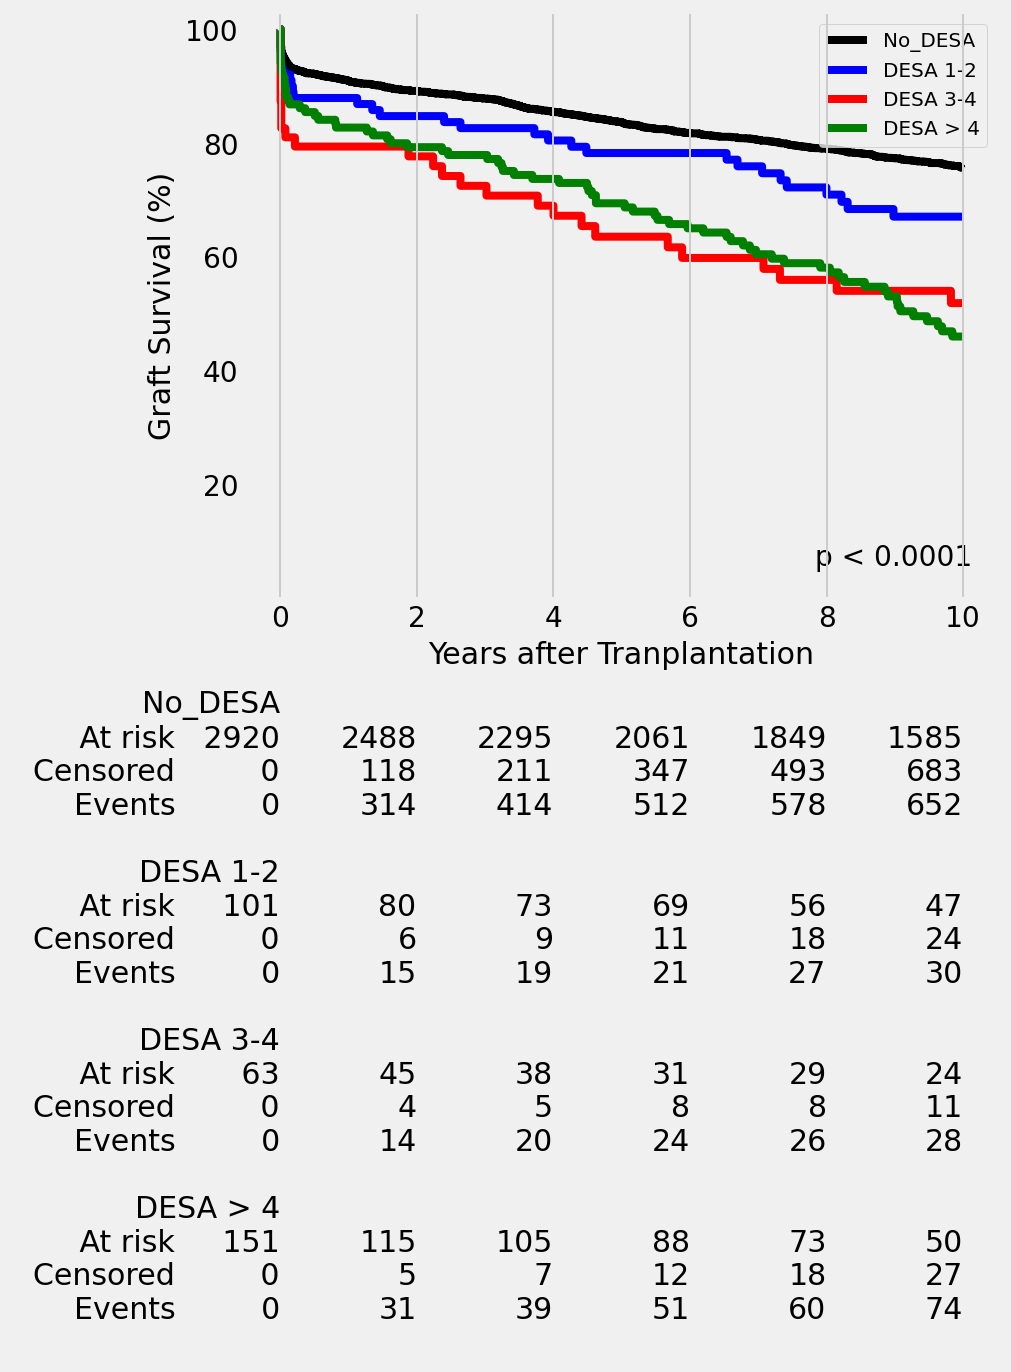

In [15]:
quant_groups = 4
df_treat_group = create_treatment_grups(df, quant_groups=quant_groups)
treatments = ['No_DESA', 'DESA_12', 'DESA_34', 'DESA_5ormore']
labels = ['No_DESA', 'DESA 1-2', 'DESA 3-4', 'DESA > 4']
colors = ['black', 'blue', 'red', 'green']

df_weight = find_ipw(df_treat_group, confounders, treatments, scaler=None, verbose=False)
kmfs, p_value, df_p = kaplan_meier_curves(df_weight, quant_groups=quant_groups,  labels=labels, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, colors=colors, grid=True)

kmfs, p_value, df_p = kaplan_meier_curves(df_weight, quant_groups=quant_groups, labels=labels, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, colors=colors, grid=False)

# Significance of difference among DESA 3-4 & DESA > 4

Since there is not a significant difference among DESA 3-4 & DESA > 4 groups we can combine both the groups in one single gourp with DESA > 3.

In [16]:
df_p_n = df_p[(df_p.Groups == 3) | (df_p.Groups == 4)]
multivariate_logrank_test(
        df_p_n['GraftSurvival10Y_R'], df_p_n['Groups'], df_p_n['FailureCode10Y_R'],
        # weights = df_p_n['w']
        ).p_value

0.8843028842413301

(214,)